#Deep Learning Project 2
#Part 1: Local Interpretable Model-Agnostic Explanations ('LIME') model implementation for detecting pneumonia.
<hr>
Team: <br>
Abhishek Singh<br>
Wilson Dsouza<br>
Sumit Sinha



# 1. Load libraries for project

Loading libraries for project
<hr>
pyyaml==5.2 <br>
matplotlib==3.1.1<br>
tqdm==4.40.2<br>
opencv_python==4.1.0.25<br>
tensorflow_gpu==2.0.1<br>
dill==0.3.0<br>
scikit_image==0.15.0<br>
numpy==1.17.4<br>
pandas==0.25.3<br>
pydicom==1.4.2<br>
imbalanced_learn==0.6.1<br>
tensorboard==2.0.2<br>
lime==0.1.1.37

In [ ]:
! pip install -r requirements.txt

     |████████████████████████████████| 266kB 8.8MB/s 
     |████████████████████████████████| 13.1MB 228kB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 26.6MB 124kB/s 
     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 153kB 54.6MB/s 
     |████████████████████████████████| 26.3MB 122kB/s 
     |████████████████████████████████| 20.0MB 1.2MB/s 
     |████████████████████████████████| 10.4MB 54.1MB/s 
     |████████████████████████████████| 35.3MB 95kB/s 
     |████████████████████████████████| 163kB 65.3MB/s 
     |████████████████████████████████| 3.8MB 48.3MB/s 
     |████████████████████████████████| 276kB 55.6MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 450kB 28.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.2-cp36-cp36m-linux_x86_64.whl size=44209 sha256=eaff3413bf5ca86f53494d45226d6fe3eb4d2546d533155dade90ac5991404d9
  Sto

# 2. Mount google drive

In [ ]:
%pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Deep Learning/covid-cxr')
%pwd

'/content/drive/MyDrive/Deep Learning/covid-cxr'

# 3. Preprocess data
<hr>


Downloaded following datasets prior to preprocessing in Google drive:



1.   Covid-chestxray-dataset repository<br>
2.   Figure1-COVID-chestxray-dataset repository<br>
3.   RSNA Pneumonia Detection Challenge dataset from Kaggle

Prior to training, data from all three datasets were amalgamated into one large dataset. The dataset consisted of a Pandas DataFrame that contains file names and associated labels. The dataset was then split randomly into training, validation and test sets, taking care to keep the class proportions constant among these sets.<br>


In [ ]:
import numpy as np
import pandas as pd
import pydicom as dicom
import yaml
import os
import pathlib
import shutil
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split


def build_dataset(cfg):
    '''
    Build a dataset of filenames and labels according to the type of classification
    :param cfg: Project config dictionary
    :return: DataFrame of file names of examples and corresponding class labels
    '''

    # Get paths of raw datasets to be included
    mila_data_path = cfg['PATHS']['MILA_DATA']
    fig1_data_path = cfg['PATHS']['FIGURE1_DATA']
    rsna_data_path = cfg['PATHS']['RSNA_DATA']

    # Assemble filenames comprising Mila dataset
    mila_df = pd.read_csv(mila_data_path + 'metadata.csv')
    mila_df['filename'] = mila_data_path.split('/')[-2] + '/images/' + mila_df['filename'].astype(str)
    mila_views_cxrs_df = (mila_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
    mila_covid_pts_df = (mila_df['finding'] == 'COVID-19')
    mila_covid_views_df = mila_df[mila_covid_pts_df & mila_views_cxrs_df]  # Images for patients diagnosed with COVID-19

    # Assemble filenames comprising Figure 1 dataset
    fig1_df = pd.read_csv(fig1_data_path + 'metadata.csv', encoding='ISO-8859-1')
    fig1_df['filename'] = ''
    for i, row in fig1_df.iterrows():
        if os.path.exists(fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'):
            fig1_df.loc[i, 'filename'] = fig1_data_path.split('/')[-2] + '/images/' + fig1_df.loc[i, 'patientid'] + '.jpg'
        else:
            fig1_df.loc[i, 'filename'] = fig1_data_path.split('/')[-2] + '/images/' + fig1_df.loc[i, 'patientid'] + '.png'
    fig1_df['view'].fillna('PA or AP', inplace=True)    # All images in this dataset are either AP or PA
    fig1_views_cxrs_df = (fig1_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
    fig1_covid_pts_df = (fig1_df['finding'] == 'COVID-19')
    fig1_covid_views_df = fig1_df[fig1_covid_pts_df & fig1_views_cxrs_df]  # Images for patients diagnosed COVID-19

    # Assemble filenames comprising RSNA dataset
    rsna_metadata_path = rsna_data_path + 'stage_2_train_labels.csv'
    rsna_df = pd.read_csv(rsna_metadata_path)
    num_rsna_imgs = cfg['DATA']['NUM_RSNA_IMGS']
    rsna_normal_df = rsna_df[rsna_df['Target'] == 0]
    rsna_pneum_df = rsna_df[rsna_df['Target'] == 1]

    # Convert dicom files of CXRs with no findings to jpg if not done already in a previous run. Select desired views.
    file_counter = 0
    normal_idxs = []
    for df_idx in rsna_normal_df.index.values.tolist():
        filename = rsna_normal_df.loc[df_idx]['patientId']
        ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
        if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
            if not os.path.exists(rsna_data_path + filename + '.jpg'):
                cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)   # Save as .jpg
            normal_idxs.append(df_idx)
            file_counter += 1
        if file_counter >= num_rsna_imgs // 2:
            break
    rsna_normal_df = rsna_normal_df.loc[normal_idxs]

    # Convert dicom files of CXRs with pneumonia to jpg if not done already in a previous run. Select desired views.
    file_counter = 0
    pneum_idxs = []
    num_remaining = num_rsna_imgs - num_rsna_imgs // 2
    for df_idx in rsna_pneum_df.index.values.tolist():
        filename = rsna_pneum_df.loc[df_idx]['patientId']
        ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
        if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
            if not os.path.exists(rsna_data_path + filename + '.jpg'):
                cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)  # Save as .jpg
            pneum_idxs.append(df_idx)
            file_counter += 1
        if file_counter >= num_remaining:
            break
    rsna_pneum_df = rsna_pneum_df.loc[pneum_idxs]

    mode = cfg['TRAIN']['CLASS_MODE']
    n_classes = len(cfg['DATA']['CLASSES'])
    class_dict = {cfg['DATA']['CLASSES'][i]: i for i in range(n_classes)}  # Map class name to number
    label_dict = {i: cfg['DATA']['CLASSES'][i] for i in range(n_classes)}  # Map class name to number

    if mode == 'binary':
        mila_covid_views_df['label'] = 1                                       # Mila images with COVID-19 diagnosis
        mila_other_views_df = mila_df[~mila_covid_pts_df & mila_views_cxrs_df]
        mila_other_views_df['label'] = 0                                       # Mila images with alternative diagnoses
        fig1_covid_views_df['label'] = 1                                       # Figure 1 images with COVID-19 diagnosis
        file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_other_views_df[['filename', 'label']],
                             fig1_covid_views_df[['filename', 'label']]], axis=0)

        rsna_df = pd.concat([rsna_normal_df, rsna_pneum_df], axis=0)
        rsna_filenames = rsna_data_path.split('/')[-2] + '/' + rsna_df['patientId'].astype(str) + '.jpg'
        rsna_file_df = pd.DataFrame({'filename': rsna_filenames, 'label': 0})

        file_df = pd.concat([file_df, rsna_file_df], axis=0)         # Combine both datasets
    else:
        mila_covid_views_df['label'] = class_dict['COVID-19']
        mila_views_pneum_df = mila_df[mila_df['finding'].isin(['SARS', 'Steptococcus', 'MERS', 'Legionella', 'Klebsiella',
                                                            'Chlamydophila', 'Pneumocystis']) & mila_views_cxrs_df]
        mila_views_pneum_df['label'] = class_dict['other_pneumonia']                 # Mila CXRs with other peumonias
        mila_views_normal_df = mila_df[mila_df['finding'].isin(['No finding']) & mila_views_cxrs_df]
        mila_views_normal_df['label'] = class_dict['normal']                         # Mila CXRs with no finding
        fig1_covid_views_df['label'] = class_dict['COVID-19']                        # Figure 1 CXRs with COVID-19 finding
        file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_views_pneum_df[['filename', 'label']],
                             mila_views_normal_df[['filename', 'label']], fig1_covid_views_df[['filename', 'label']]], axis=0)

        # Organize some files from RSNA dataset into "normal", and "pneumonia" XRs
        rsna_normal_filenames = rsna_data_path.split('/')[-2] + '/' + rsna_normal_df['patientId'].astype(str) + '.jpg'
        rsna_pneum_filenames = rsna_data_path.split('/')[-2] + '/' + rsna_pneum_df['patientId'].astype(str) + '.jpg'
        rsna_normal_file_df = pd.DataFrame({'filename': rsna_normal_filenames, 'label': class_dict['normal']})
        rsna_pneum_file_df = pd.DataFrame({'filename': rsna_pneum_filenames, 'label': class_dict['other_pneumonia']})
        rsna_file_df = pd.concat([rsna_normal_file_df, rsna_pneum_file_df], axis=0)

        file_df = pd.concat([file_df, rsna_file_df], axis=0)  # Combine both datasets

    file_df['label_str'] = file_df['label'].map(label_dict) # Add column for string representation of label
    return file_df


def remove_text(img):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    mask = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    return result


def preprocess(cfg=None):
    '''
    Preprocess and partition image data. Assemble all image file paths and partition into training, validation and
    test sets. Copy raw images to folders for training, validation and test sets.
    :param cfg: Optional parameter to set your own config object.
    '''

    if cfg is None:
        cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))  # Load config data

    # Build dataset based on type of classification
    file_df = build_dataset(cfg)

    # Split dataset into train, val and test sets
    val_split = cfg['DATA']['VAL_SPLIT']
    test_split = cfg['DATA']['TEST_SPLIT']
    file_df_train, file_df_test = train_test_split(file_df, test_size=test_split, stratify=file_df['label'])
    relative_val_split = val_split / (1 - test_split)  # Calculate fraction of train_df to be used for validation
    file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_val_split,
                                                      stratify=file_df_train['label'])

    # Save training, validation and test sets
    if not os.path.exists(cfg['PATHS']['PROCESSED_DATA']):
        os.makedirs(cfg['PATHS']['PROCESSED_DATA'])
    file_df_train.to_csv(cfg['PATHS']['TRAIN_SET'])
    file_df_val.to_csv(cfg['PATHS']['VAL_SET'])
    file_df_test.to_csv(cfg['PATHS']['TEST_SET'])
    return

if __name__ == '__main__':
    preprocess()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 4. Train NN model
<hr>


A deep convolutional neuralnetwork architecture (that employs residual connections) is being trained to perform binary classification- to detect whether an X-ray shows evidence of COVID-19 infection. The classifier was to assign X-ray imagesto either a non-COVID-19 class or a COVID-19 class.The model is trained using the Adam optimizer and categorical cross-entropy loss.<br>

Refer to config.yaml file for additonal details of training paramaters.

Found 1489 non-validated image filenames belonging to 2 classes.
Found 146 non-validated image filenames belonging to 2 classes.
Found 182 non-validated image filenames belonging to 2 classes.
Class weights:  [26.589285714285715, 0.07643737166324435]
Training distribution:  ['Class COVID-19: 28. ', 'Class non-COVID-19: 1461. ']
MODEL CONFIG:  {'KERNEL_SIZE': '(3,3)', 'STRIDES': '(1,1)', 'INIT_FILTERS': 16, 'FILTER_EXP_BASE': 3, 'MAXPOOL_SIZE': '(2,2)', 'CONV_BLOCKS': 3, 'NODES_DENSE0': 128, 'LR': 1e-05, 'OPTIMIZER': 'adam', 'DROPOUT': 0.4, 'L2_LAMBDA': 0.0001}
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0 (Conv2D)    

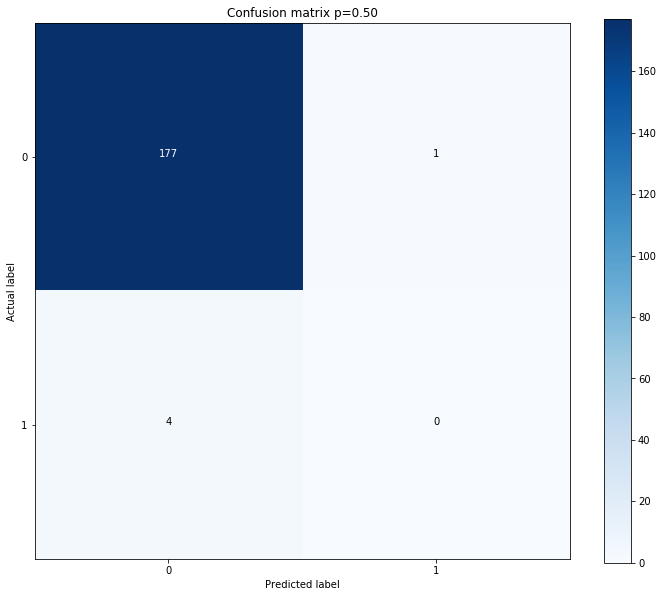

In [ ]:
import pandas as pd
import yaml
import os
import datetime
import random
import dill
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.summary as tf_summary
from imblearn.over_sampling import RandomOverSampler
from math import ceil
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard.plugins.hparams import api as hp
from src.models.models import *
from src.visualization.visualize import *
from src.custom.metrics import F1Score
from src.data.preprocess import remove_text

def get_class_weights(histogram, class_multiplier=None):
    '''
    Computes weights for each class to be applied in the loss function during training.
    :param histogram: A list depicting the number of each item in different class
    :param class_multiplier: List of values to multiply the calculated class weights by. For further control of class weighting.
    :return: A dictionary containing weights for each class
    '''
    weights = [None] * len(histogram)
    for i in range(len(histogram)):
        weights[i] = (1.0 / len(histogram)) * sum(histogram) / histogram[i]
    class_weight = {i: weights[i] for i in range(len(histogram))}
    if class_multiplier is not None:
        class_weight = [class_weight[i] * class_multiplier[i] for i in range(len(histogram))]
    print("Class weights: ", class_weight)
    return class_weight


def random_minority_oversample(train_set):
    '''
    Oversample the minority class using the specified algorithm
    :param train_set: Training set image file names and labels
    :return: A new training set containing oversampled examples
    '''
    X_train = train_set[[x for x in train_set.columns if x != 'label']].to_numpy()
    if X_train.shape[1] == 1:
        X_train = np.expand_dims(X_train, axis=-1)
    Y_train = train_set['label'].to_numpy()
    sampler = RandomOverSampler(random_state=np.random.randint(0, high=1000))
    X_resampled, Y_resampled = sampler.fit_resample(X_train, Y_train)
    filenames = X_resampled[:, 1]     # Filename is in second column
    label_strs = X_resampled[:, 2]    # Class name is in second column
    print("Train set shape before oversampling: ", X_train.shape, " Train set shape after resampling: ", X_resampled.shape)
    train_set_resampled = pd.DataFrame({'filename': filenames, 'label': Y_resampled, 'label_str': label_strs})
    return train_set_resampled


def train_model(cfg, data, callbacks, verbose=1):
    '''
    Train a and evaluate model on given data.
    :param cfg: Project config (from config.yml)
    :param data: dict of partitioned dataset
    :param callbacks: list of callbacks for Keras model
    :param verbose: Verbosity mode to pass to model.fit_generator()
    :return: Trained model and associated performance metrics on the test set
    '''

    # If set in config file, oversample the minority class
    if cfg['TRAIN']['IMB_STRATEGY'] == 'random_oversample':
        data['TRAIN'] = random_minority_oversample(data['TRAIN'])

    # Create ImageDataGenerators
    train_img_gen = ImageDataGenerator(rotation_range=10, preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    val_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)

    # Create DataFrameIterators
    img_shape = tuple(cfg['DATA']['IMG_DIM'])
    y_col = 'label_str'
    class_mode = 'categorical'
    train_generator = train_img_gen.flow_from_dataframe(dataframe=data['TRAIN'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False)
    val_generator = val_img_gen.flow_from_dataframe(dataframe=data['VAL'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False, shuffle=False)

    # Save model's ordering of class indices
    dill.dump(test_generator.class_indices, open(cfg['PATHS']['OUTPUT_CLASS_INDICES'], 'wb'))

    # Apply class imbalance strategy. We have many more X-rays negative for COVID-19 than positive.
    histogram = np.bincount(np.array(train_generator.labels).astype(int))  # Get class distribution
    class_weight = None
    if cfg['TRAIN']['IMB_STRATEGY'] == 'class_weight':
        class_multiplier = cfg['TRAIN']['CLASS_MULTIPLIER']
        class_multiplier = [class_multiplier[cfg['DATA']['CLASSES'].index(c)] for c in test_generator.class_indices]
        class_weight = get_class_weights(histogram, class_multiplier)

    # Define metrics.
    covid_class_idx = test_generator.class_indices['COVID-19']   # Get index of COVID-19 class
    thresholds = 1.0 / len(cfg['DATA']['CLASSES'])      # Binary classification threshold for a class
    metrics = ['accuracy', CategoricalAccuracy(name='accuracy'),
               Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
               Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
               AUC(name='auc'),
               F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

    # Define the model.
    print('Training distribution: ', ['Class ' + list(test_generator.class_indices.keys())[i] + ': ' + str(histogram[i]) + '. '
           for i in range(len(histogram))])
    input_shape = cfg['DATA']['IMG_DIM'] + [3]
    num_gpus = cfg['TRAIN']['NUM_GPUS']
    if cfg['TRAIN']['MODEL_DEF'] == 'dcnn_resnet':
        model_def = dcnn_resnet
    elif cfg['TRAIN']['MODEL_DEF'] == 'resnet50v2':
        model_def = resnet50v2
    else:
        model_def = resnet101v2
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=num_gpus)
    else:
        n_classes = len(cfg['DATA']['CLASSES'])
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_MULTICLASS'], input_shape, metrics, n_classes, output_bias=output_bias,
                          gpus=num_gpus)

    # Train the model.
    steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
    val_steps = ceil(val_generator.n / val_generator.batch_size)
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=cfg['TRAIN']['EPOCHS'],
                                  validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                                  verbose=verbose, class_weight=class_weight)

    # Run the model on the test set and print the resulting performance metrics.
    test_results = model.evaluate_generator(test_generator, verbose=1)
    test_metrics = {}
    test_summary_str = [['**Metric**', '**Value**']]
    for metric, value in zip(model.metrics_names, test_results):
        test_metrics[metric] = value
        print(metric, ' = ', value)
        test_summary_str.append([metric, str(value)])
    return model, test_metrics, test_generator


def multi_train(cfg, data, callbacks, base_log_dir):
    '''
    Trains a model a series of times and returns the model with the best test set metric (specified in cfg)
    :param cfg: Project config (from config.yml)
    :param data: Partitioned dataset
    :param callbacks: List of callbacks to pass to model.fit()
    :param base_log_dir: Base directory to write logs
    :return: The trained Keras model with best test set performance on the metric specified in cfg
    '''

    # Load order of metric preference
    metric_preference = cfg['TRAIN']['METRIC_PREFERENCE']
    best_metrics = dict.fromkeys(metric_preference, 0.0)
    if 'loss' in metric_preference:
        best_metrics['loss'] = 100000.0

    # Train NUM_RUNS models and return the best one according to the preferred metrics
    for i in range(cfg['TRAIN']['NUM_RUNS']):
        print("Training run ", i+1, " / ", cfg['TRAIN']['NUM_RUNS'])
        cur_callbacks = callbacks.copy()
        cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        if base_log_dir is not None:
            log_dir = base_log_dir + cur_date
            cur_callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))

        # Train the model and evaluate performance on test set
        new_model, test_metrics, test_generator = train_model(cfg, data, cur_callbacks, verbose=1)

        # Log test set results and images
        if base_log_dir is not None:
            log_test_results(cfg, new_model, test_generator, test_metrics, log_dir)

        # If this model outperforms the previous ones based on the specified metric preferences, save this one.
        for i in range(len(metric_preference)):
            if (((metric_preference[i] == 'loss') and (test_metrics[metric_preference[i]] < best_metrics[metric_preference[i]]))
                    or ((metric_preference[i] != 'loss') and (test_metrics[metric_preference[i]] > best_metrics[metric_preference[i]]))):
                best_model = new_model
                best_metrics = test_metrics
                best_generator = test_generator
                best_model_date = cur_date
                break
            elif (test_metrics[metric_preference[i]] == best_metrics[metric_preference[i]]):
                continue
            else:
                break

    print("Best model test metrics: ", best_metrics)
    return best_model, best_metrics, best_generator, best_model_date


def random_hparam_search(cfg, data, callbacks, log_dir):
    '''
    Conduct a random hyperparameter search over the ranges given for the hyperparameters in config.yml and log results
    in TensorBoard. Model is trained x times for y random combinations of hyperparameters.
    :param cfg: Project config
    :param data: Dict containing the partitioned datasets
    :param callbacks: List of callbacks for Keras model (excluding TensorBoard)
    :param log_dir: Base directory in which to store logs
    :return: (Last model trained, resultant test set metrics, test data generator)
    '''

    # Define HParam objects for each hyperparameter we wish to tune.
    hp_ranges = cfg['HP_SEARCH']['RANGES']
    HPARAMS = []
    HPARAMS.append(hp.HParam('KERNEL_SIZE', hp.Discrete(hp_ranges['KERNEL_SIZE'])))
    HPARAMS.append(hp.HParam('MAXPOOL_SIZE', hp.Discrete(hp_ranges['MAXPOOL_SIZE'])))
    HPARAMS.append(hp.HParam('INIT_FILTERS', hp.Discrete(hp_ranges['INIT_FILTERS'])))
    HPARAMS.append(hp.HParam('FILTER_EXP_BASE', hp.IntInterval(hp_ranges['FILTER_EXP_BASE'][0], hp_ranges['FILTER_EXP_BASE'][1])))
    HPARAMS.append(hp.HParam('NODES_DENSE0', hp.Discrete(hp_ranges['NODES_DENSE0'])))
    HPARAMS.append(hp.HParam('CONV_BLOCKS', hp.IntInterval(hp_ranges['CONV_BLOCKS'][0], hp_ranges['CONV_BLOCKS'][1])))
    HPARAMS.append(hp.HParam('DROPOUT', hp.Discrete(hp_ranges['DROPOUT'])))
    HPARAMS.append(hp.HParam('LR', hp.RealInterval(hp_ranges['LR'][0], hp_ranges['LR'][1])))
    HPARAMS.append(hp.HParam('OPTIMIZER', hp.Discrete(hp_ranges['OPTIMIZER'])))
    HPARAMS.append(hp.HParam('L2_LAMBDA', hp.Discrete(hp_ranges['L2_LAMBDA'])))
    HPARAMS.append(hp.HParam('BATCH_SIZE', hp.Discrete(hp_ranges['BATCH_SIZE'])))
    HPARAMS.append(hp.HParam('IMB_STRATEGY', hp.Discrete(hp_ranges['IMB_STRATEGY'])))

    # Define test set metrics that we wish to log to TensorBoard for each training run
    HP_METRICS = [hp.Metric(metric, display_name='Test ' + metric) for metric in cfg['HP_SEARCH']['METRICS']]

    # Configure TensorBoard to log the results
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams_config(hparams=HPARAMS, metrics=HP_METRICS)

    # Complete a number of training runs at different hparam values and log the results.
    repeats_per_combo = cfg['HP_SEARCH']['REPEATS']   # Number of times to train the model per combination of hparams
    num_combos = cfg['HP_SEARCH']['COMBINATIONS']     # Number of random combinations of hparams to attempt
    num_sessions = num_combos * repeats_per_combo       # Total number of runs in this experiment
    model_type = 'DCNN_BINARY' if cfg['TRAIN']['CLASS_MODE'] == 'binary' else 'DCNN_MULTICLASS'
    trial_id = 0
    for group_idx in range(num_combos):
        rand = random.Random()
        HPARAMS = {h: h.domain.sample_uniform(rand) for h in HPARAMS}
        hparams = {h.name: HPARAMS[h] for h in HPARAMS}  # To pass to model definition
        for repeat_idx in range(repeats_per_combo):
            trial_id += 1
            print("Running training session %d/%d" % (trial_id, num_sessions))
            print("Hparam values: ", {h.name: HPARAMS[h] for h in HPARAMS})
            trial_logdir = os.path.join(log_dir, str(trial_id))     # Need specific logdir for each trial
            callbacks_hp = callbacks + [TensorBoard(log_dir=trial_logdir, profile_batch=0, write_graph=False)]

            # Set values of hyperparameters for this run in config file.
            for h in hparams:
                if h in ['LR', 'L2_LAMBDA']:
                    val = 10 ** hparams[h]      # These hyperparameters are sampled on the log scale.
                else:
                    val = hparams[h]
                cfg['NN'][model_type][h] = val

            # Set some hyperparameters that are not specified in model definition.
            cfg['TRAIN']['BATCH_SIZE'] = hparams['BATCH_SIZE']
            cfg['TRAIN']['IMB_STRATEGY'] = hparams['IMB_STRATEGY']

            # Run a training session and log the performance metrics on the test set to HParams dashboard in TensorBoard
            with tf.summary.create_file_writer(trial_logdir).as_default():
                hp.hparams(HPARAMS, trial_id=str(trial_id))
                model, test_metrics, test_generator = train_model(cfg, data, callbacks_hp, verbose=0)
                for metric in HP_METRICS:
                    if metric._tag in test_metrics:
                        tf.summary.scalar(metric._tag, test_metrics[metric._tag], step=1)   # Log test metric
    return


def log_test_results(cfg, model, test_generator, test_metrics, log_dir):
    '''
    Visualize performance of a trained model on the test set. Optionally save the model.
    :param cfg: Project config
    :param model: A trained Keras model
    :param test_generator: A Keras generator for the test set
    :param test_metrics: Dict of test set performance metrics
    :param log_dir: Path to write TensorBoard logs
    '''

    # Visualization of test results
    test_predictions = model.predict_generator(test_generator, verbose=0)
    test_labels = test_generator.labels
    covid_idx = test_generator.class_indices['COVID-19']
    plt = plot_roc("Test set", test_labels, test_predictions, class_id=covid_idx)
    roc_img = plot_to_tensor()
    plt = plot_confusion_matrix(test_labels, test_predictions, class_id=covid_idx)
    cm_img = plot_to_tensor()

    # Log test set results and plots in TensorBoard
    writer = tf_summary.create_file_writer(logdir=log_dir)

    # Create table of test set metrics
    test_summary_str = [['**Metric**','**Value**']]
    thresholds = cfg['TRAIN']['THRESHOLDS']  # Load classification thresholds
    for metric in test_metrics:
        if metric in ['precision', 'recall'] and isinstance(metric, list):
            metric_values = dict(zip(thresholds, test_metrics[metric]))
        else:
            metric_values = test_metrics[metric]
        test_summary_str.append([metric, str(metric_values)])

    # Create table of model and train config values
    hparam_summary_str = [['**Variable**', '**Value**']]
    for key in cfg['TRAIN']:
        hparam_summary_str.append([key, str(cfg['TRAIN'][key])])
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])
    else:
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])

    # Write to TensorBoard logs
    with writer.as_default():
        tf_summary.text(name='Test set metrics', data=tf.convert_to_tensor(test_summary_str), step=0)
        tf_summary.text(name='Run hyperparameters', data=tf.convert_to_tensor(hparam_summary_str), step=0)
        tf_summary.image(name='ROC Curve (Test Set)', data=roc_img, step=0)
        tf_summary.image(name='Confusion Matrix (Test Set)', data=cm_img, step=0)
    return

def train_experiment(cfg=None, experiment='single_train', save_weights=True, write_logs=True):
    '''
    Defines and trains HIFIS-v2 model. Prints and logs relevant metrics.
    :param experiment: The type of training experiment. Choices are {'single_train'}
    :param save_weights: A flag indicating whether to save the model weights
    :param write_logs: A flag indicating whether to write TensorBoard logs
    :return: A dictionary of metrics on the test set
    '''

    # Load project config data
    if cfg is None:
        cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))

    # Set logs directory
    cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    log_dir = cfg['PATHS']['LOGS'] + "training\\" + cur_date if write_logs else None
    if not os.path.exists(cfg['PATHS']['LOGS'] + "training\\"):
        os.makedirs(cfg['PATHS']['LOGS'] + "training\\")

    # Load dataset file paths and labels
    data = {}
    data['TRAIN'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    data['VAL'] = pd.read_csv(cfg['PATHS']['VAL_SET'])
    data['TEST'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Set callbacks.
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=cfg['TRAIN']['PATIENCE'], mode='min', restore_best_weights=True)
    callbacks = [early_stopping]

    # Conduct the desired train experiment
    if experiment == 'hparam_search':
        log_dir = cfg['PATHS']['LOGS'] + "hparam_search\\" + cur_date
        random_hparam_search(cfg, data, callbacks, log_dir)
    else:
        if experiment == 'multi_train':
            base_log_dir = cfg['PATHS']['LOGS'] + "training\\" if write_logs else None
            model, test_metrics, test_generator, cur_date = multi_train(cfg, data, callbacks, base_log_dir)
        else:
            if write_logs:
                tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
                callbacks.append(tensorboard)
            model, test_metrics, test_generator = train_model(cfg, data, callbacks)
            if write_logs:
                log_test_results(cfg, model, test_generator, test_metrics, log_dir)
        if save_weights:
            model_path = cfg['PATHS']['MODEL_WEIGHTS'] + 'model' + cur_date + '.h5'
            save_model(model, model_path)  # Save the model's weights
    return


if __name__ == '__main__':
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    train_experiment(cfg=cfg, experiment=cfg['TRAIN']['EXPERIMENT_TYPE'], save_weights=True, write_logs=True)

See above for ROC Curve and Confusion Matrix based on test set predictions.<br>

The trained model's weights are located in 'model20201120-213705.h5 file'.<br>

# 5. LIME Explaination
<hr>

Local Interpretable Model-Agnostic Explanations (i.e. LIME) is being used to explain the predictions of the neural network classifier. LIME perturbs the features in an example and fits a linear model to approximate the neural network at the local region in the feature space surrounding the example. It then uses the linear model to determine which features were most contributory to the model's prediction for that example. By applying LIME to the trained model, we can conduct informed feature engineering based on any obviously inconsequential features we see insights from domain experts.

Found 182 non-validated image filenames belonging to 2 classes.


Intercept -3.6641717047548023e-06
Prediction_local [1.70752994e-05]
Right: 1.7488007e-06
Intercept 1.0000036737417872
Prediction_local [0.99998292]
Right: 0.9999982
Explanation time = 7.317429 seconds


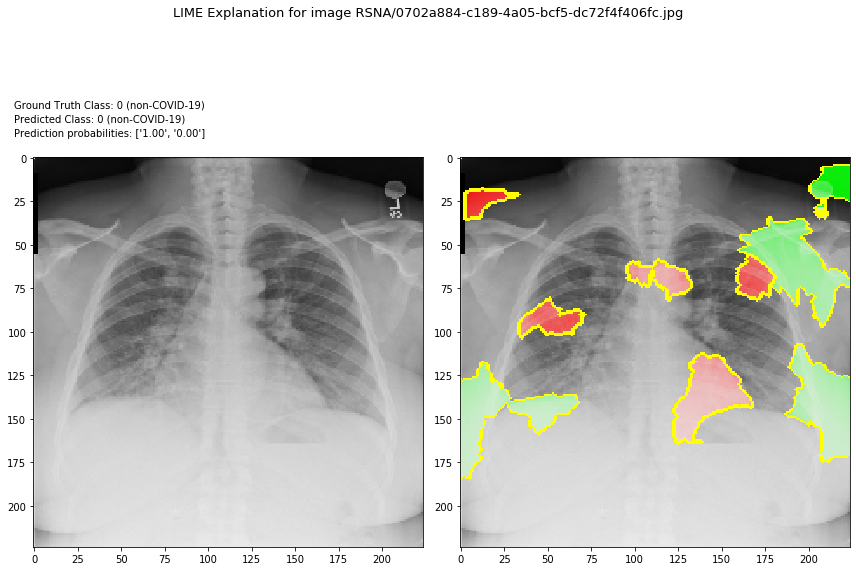

In [ ]:
from lime.lime_image import *
import pandas as pd
import yaml
import os
import datetime
import dill
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from src.visualization.visualize import visualize_explanation
from src.predict import predict_instance, predict_and_explain
from src.data.preprocess import remove_text


def setup_lime():
    '''
    Load relevant information and create a LIME Explainer
    :return: dict containing important information and objects for explanation experiments
    '''

    # Load relevant constants from project config file
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    lime_dict = {}
    lime_dict['NUM_SAMPLES'] = cfg['LIME']['NUM_SAMPLES']
    lime_dict['NUM_FEATURES'] = cfg['LIME']['NUM_FEATURES']
    lime_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    lime_dict['RAW_DATA_PATH'] = cfg['PATHS']['RAW_DATA']
    lime_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    lime_dict['PRED_THRESHOLD'] = cfg['PREDICTION']['THRESHOLD']
    lime_dict['CLASSES'] = cfg['DATA']['CLASSES']
    lime_dict['CLASS_MODE'] = cfg['TRAIN']['CLASS_MODE']
    lime_dict['COVID_ONLY'] = cfg['LIME']['COVID_ONLY']
    KERNEL_WIDTH = cfg['LIME']['KERNEL_WIDTH']
    FEATURE_SELECTION = cfg['LIME']['FEATURE_SELECTION']

    # Load train and test sets
    lime_dict['TRAIN_SET'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    lime_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=lime_dict['TEST_SET'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', validate_filenames=False, shuffle=False)
    lime_dict['TEST_GENERATOR'] = test_generator

    # Define the LIME explainer
    lime_dict['EXPLAINER'] = LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION,
                                                verbose=True)
    dill.dump(lime_dict['EXPLAINER'], open(cfg['PATHS']['LIME_EXPLAINER'], 'wb'))    # Serialize the explainer

    # Load trained model's weights
    lime_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)

    return lime_dict


def explain_xray(lime_dict, idx, save_exp=True):
    '''
    Make a prediction and provide a LIME explanation
    :param lime_dict: dict containing important information and objects for explanation experiments
    :param idx: index of image in test set to explain
    :param save_exp: Boolean indicating whether to save the explanation visualization
    '''

    # Get i'th preprocessed image in test set
    lime_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = lime_dict['TEST_GENERATOR'].next()
    x = np.squeeze(x, axis=0)

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread(lime_dict['RAW_DATA_PATH'] + lime_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(lime_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Make a prediction for this image and retrieve a LIME explanation for the prediction
    start_time = datetime.datetime.now()
    explanation, probs = predict_and_explain(x, lime_dict['MODEL'], lime_dict['EXPLAINER'],
                                      lime_dict['NUM_FEATURES'], lime_dict['NUM_SAMPLES'])
    print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")


    # Get image filename and label
    img_filename = lime_dict['TEST_SET']['filename'][idx]
    label = lime_dict['TEST_SET']['label'][idx]

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_dict['TEST_GENERATOR'].class_indices]

    # Visualize the LIME explanation and optionally save it to disk
    if save_exp:
        file_path = lime_dict['IMG_PATH']
    else:
        file_path = None
    if lime_dict['COVID_ONLY'] == True:
        label_to_see = lime_dict['TEST_GENERATOR'].class_indices['COVID-19']
    else:
        label_to_see = 'top'
    _ = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                          dir_path=file_path)
    return


if __name__ == '__main__':
    lime_dict = setup_lime()
    i = 0                                                       # Select i'th image in test set
    explain_xray(lime_dict, i, save_exp=True)                   # Generate explanation for image

An image above has been generated that depicts the superpixels (i.e. image regions) that were most contributory to the model's prediction. Superpixels that contributed toward a prediction of COVID-19 are coloured green and superpixels that contributed against a prediction of COVID-19 are coloured red.